# Training Dataset Overview

### 1. Import libraries and load data from database

In [1]:
# Import libraries
%matplotlib inline

import joblib
import re
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tribui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/tribui/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Load data from database
engine = create_engine('sqlite:///../data/messages.db')
df = pd.read_sql('SELECT * FROM messages', engine)
df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2. Genre counts

In [3]:
genre_counts = df.groupby('genre').count()['message']
genre_names = genre_counts.index.tolist()
genre_counts

genre
direct    10766
news      13054
social     2396
Name: message, dtype: int64

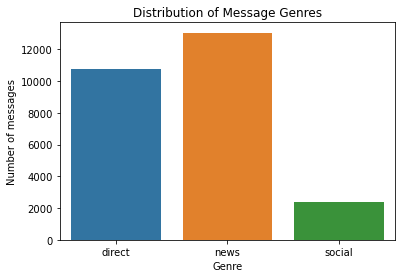

In [4]:
sns.barplot(x=genre_names, y=genre_counts)
plt.title('Distribution of Message Genres')
plt.ylabel('Number of messages')
plt.xlabel('Genre');

### 3. Message word counts

In [5]:
word_count = df.message.apply(lambda s: len(s.split())).sort_values(ascending=False)
word_count = word_count[word_count <= 100]
word_count.head()

19862    97
21287    97
12911    97
10661    97
10678    96
Name: message, dtype: int64

Text(0.5, 0, 'Word Count')

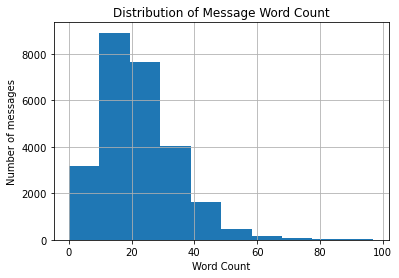

In [6]:
word_count.hist()
plt.title('Distribution of Message Word Count')
plt.ylabel('Number of messages')
plt.xlabel('Word Count')

### 4. Category counts

In [7]:
cat_counts = df.iloc[:, 4:].sum().sort_values(ascending=False)[:10]
cat_names = cat_counts.index.tolist()
cat_counts

related            20282
aid_related        10860
weather_related     7297
direct_report       5075
request             4474
other_aid           3446
food                2923
earthquake          2455
storm               2443
shelter             2314
dtype: int64

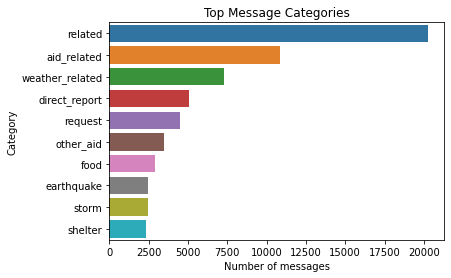

In [8]:
sns.barplot(x=cat_counts, y=cat_names)
plt.title('Top Message Categories')
plt.ylabel('Category')
plt.xlabel('Number of messages');

### 5. Top words

In [9]:
# Stopword list
stop = stopwords.words('english')

# Define a function to find the 10 most common words
def get_top_words(txt, num_words=10):
    tfidf = TfidfVectorizer(stop_words=stop, max_features=num_words)
    tfidf.fit(txt)
    words = tfidf.vocabulary_
    
    for word in words:
        words[word] = txt[txt.str.contains(word)].count()
    return pd.Series(words).sort_values(ascending=False)

top_counts = get_top_words(df.message)
top_words = top_counts.index.tolist()
top_counts

us            7403
water         2581
people        2468
food          2420
need          2347
help          2249
earthquake    1584
like          1541
would         1368
please        1120
dtype: int64

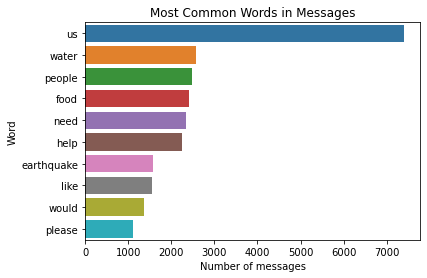

In [10]:
sns.barplot(top_counts, top_words)
plt.title('Most Common Words in Messages')
plt.ylabel('Word')
plt.xlabel('Number of messages');

### 6. Code for Flask app

In [11]:
# Genre counts
genre_counts = df.groupby('genre').count()['message']
genre_names = genre_counts.index.tolist()

# Message word counts
word_counts = df.message.apply(lambda s: len(s.split()))
word_counts = word_counts[word_counts <= 100]

# Category counts
cat_counts = df.iloc[:, 4:].sum().sort_values()[-10:]
cat_names = cat_counts.index.tolist()

# Top word
top_counts = get_top_words(df.message)
top_words = top_counts.index.tolist()

# Plotly setup
graphs = [

    # Genre counts
    {
        'data': [
            Bar(
                x=genre_names,
                y=genre_counts
            )
        ],
        'layout': {
            'title': 'Distribution of Message Genres',
            'yaxis': {'title': "Number of messages"},
            'xaxis': {'title': "Genre"}
        }
    },

    # Message word counts
    {
        'data': [
            Histogram(
                x=word_counts
            )
        ],
        'layout': {
            'title': 'Distribution of Message Word Counts',
            'yaxis': {'title': "Number of messages"},
            'xaxis': {'title': "Word count"}
        }
    },

    # Category counts
    {
        'data': [
            Bar(
                x=cat_counts,
                y=cat_names,
                orientation='h'
            )
        ],
        'layout': {
            'title': 'Top Message Categories',
            'yaxis': {'title': "Category"},
            'xaxis': {'title': "Number of Messages"},
            'margin': {'l': 100}
        }
    },

    # Top word counts
    {
        'data': [
            Bar(
                x=top_counts,
                y=top_words,
                orientation='h'
            )
        ],
        'layout': {
            'title': 'Most Common Words in Messages',
            'yaxis': {'title': "Word"},
            'xaxis': {'title': "Number of Messages"},
            'margin': {'l': 100}
        }
    }
]

NameError: name 'Bar' is not defined